In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords
import gseapy as gp

import seaborn as sns
sns.set_theme(style='white')


import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()

In [2]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')


regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
concat_adata = ad.concat(adata_slides)

concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].astype('category')
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)

In [3]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')
all_obs = pd.concat(scanpy_res,axis=0)
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

all_obs = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    all_obs = pd.concat([all_obs,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
all_obs['predicted_region'] = all_obs['predicted_region'].astype('category').cat.set_categories(regions)

## Macrophage-persist interaction visualization for Ketola

In [55]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
untreated_samples = [k for k in treat_info.keys() if treat_info[k] == 'untreated']

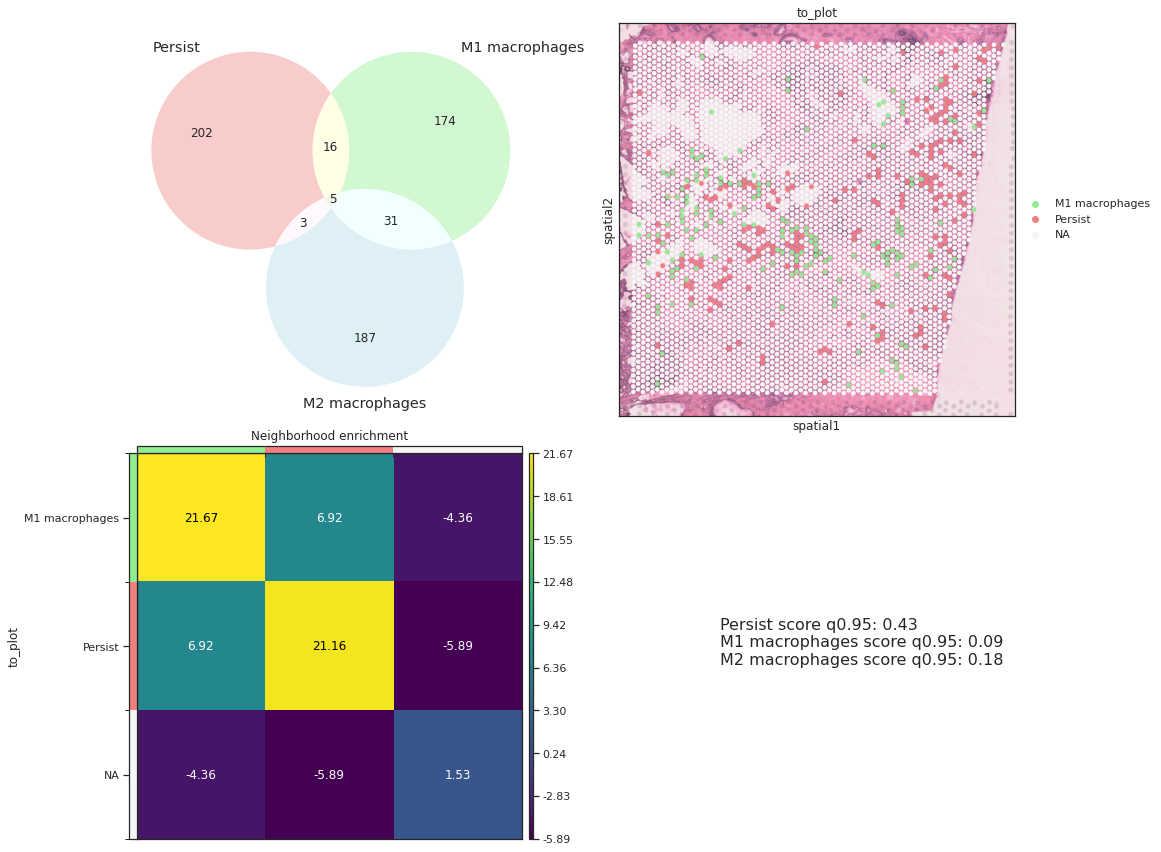

In [53]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn2
sns.set_theme(style='white')



for sample in untreated_samples:

    obs_data = adata_slides[sample].obs.copy()

    def q_therehold_spots(dat,col,quant=0.99):
        q_thr = dat[col].quantile(quant)
        bcode_set = set(dat[dat[col] > q_thr]['sample_id'].index)
        return bcode_set

    # Define your three sets
    set1 = q_therehold_spots(obs_data,'Persist')
    set2 = q_therehold_spots(obs_data,'M1 macrophages')
    set3 = q_therehold_spots(obs_data,'M2 macrophages')


    ##### Spatial plot ##### 


    slide = adata_slides[sample].copy()

    idx_list1 = list(q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'M2 macrophages'))
    idx_list2 = list(q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M2 macrophages'))
    #idx_list2 = M1_confident.index.tolist()

    slide.obs['to_plot'] = 'NA'
    slide.obs['to_plot'] = slide.obs['to_plot'].astype('category')

    slide.obs['to_plot'] = slide.obs['to_plot'].cat.set_categories(['M1 macrophages','Persist','NA'])

    slide.obs.loc[idx_list1,'to_plot'] = 'Persist'
    slide.obs.loc[idx_list2,'to_plot'] = 'M1 macrophages' 

    pal = sns.color_palette(['lightgreen','lightcoral','whitesmoke'])

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))


    # Create the Venn diagram
    venn3([set1, set2, set3], ('Persist', 'M1 macrophages', 'M2 macrophages'),ax=ax1,set_colors=['lightcoral','lightgreen','lightblue'])

    sc.pl.spatial(slide,color='to_plot',vmin=min, vmax=max,
                                crop_coord=sample_crop_coord[sample],
                                colorbar_loc=None, size=1.3, alpha_img=0.8, palette=pal,
                                ax=ax2,show=False
                                )

    sq.gr.nhood_enrichment(slide, cluster_key="to_plot",show_progress_bar=False)
    sq.pl.nhood_enrichment(slide, cluster_key="to_plot",annotate=True,ax=ax3)

    ax4.axis('off')
    ax4.text(0.3, 0.5, "Persist score q0.95: {:.2f}\nM1 macrophages score q0.95: {:.2f}\nM2 macrophages score q0.95: {:.2f}".format(
        obs_data['Persist'].quantile(0.95),
        obs_data['M1 macrophages'].quantile(0.95),
        obs_data['M2 macrophages'].quantile(0.95)),
        ha='left', va='center',fontsize=16)

    plt.tight_layout()
    plt.savefig('./plots/macrophage_persist_proximity_in_untreated/'+sample+'_multi_panel.pdf')

## Plot sample grids 

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Normalize by the number of cells inferred to be present at each location

cell_types = adata_slides[samples[0]].obs.columns[16:].tolist()

cell_proportions = {}

for sample in samples:
    df = adata_slides[sample].obs[cell_types]
    inferred_cell_numbers = df.sum(axis=1).tolist()
    
    df = df.div(df.sum(axis=1), axis=0)
    df['n_cells'] = inferred_cell_numbers
    cell_proportions[sample] = df.copy()


for sample in samples:
    slide = adata_slides[sample]
    df = cell_proportions[sample]
    for ctype in cell_types:
        slide.obs[ctype] = df[ctype].copy()

    slide.obs['n_cells'] = df['n_cells'].copy()

### Plot proportional inferred cell counts

In [ ]:
# Plot the inferred cell prevalences as a test
# You can plot whichever metric here
for var_to_plot in cell_types:

    it=0

    concat_obs = pd.DataFrame(columns=adata_slides[samples[it]].obs.columns)
    for slide in adata_slides:
        concat_obs = pd.concat([concat_obs,adata_slides[slide].obs.copy()],axis=0)

    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)
    
    min = 0#concat_obs[var_to_plot].quantile(0.05)
    max = 1#concat_obs[var_to_plot].quantile(0.95)


    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                sc.pl.spatial(adata_slides[samples[it]],color=var_to_plot,title=samples[it],
                            vmin=min, vmax=max,crop_coord=sample_crop_coord[samples[it]],
                            colorbar_loc=None, cmap='viridis', size=1.3, alpha_img=0.8, legend_loc=None,
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create a custom axes for the colorbar
    cax = fig.add_axes([0.66, 0.1, 0.3, 0.04])
    # draw the colorbar on the custom axes with horizontal orientation
    fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min, vmax=max), cmap='viridis'), cax=cax, orientation='horizontal')
    cax.set_title(var_to_plot)


    plt.savefig('./plots/all_samples_grid/'+var_to_plot+'_on_all_spatial_sections.pdf')
    plt.clf()


### Plot predicted regions on all samples

In [ ]:
import matplotlib.patches as patches

regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Create color legend
color_dict = dict(zip(regions,region_colors))

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

In [ ]:

it=0
fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

for i in range(5):
    for j in range(8):
        
        if it < len(samples):
            sc.pl.spatial(adata_slides[samples[it]],color='predicted_region',title=samples[it],
                        crop_coord=sample_crop_coord[samples[it]],
                        size=1.3, alpha_img=0.8, legend_loc=None,
                        ax=axs[i,j],show=False
                        )

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()

# create custom axes for the annotation legend 
cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

cax1.axis('off')
cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
cax2.axis('off')
cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


plt.savefig('./plots/all_samples_grid/predicted_regions_on_all_spatial_sections.pdf')
plt.clf()
#plt.show()


### Plot predicted regions one at a time

In [ ]:

for region_of_interest in regions:
    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                slide = adata_slides[samples[it]].copy()
                slide.obs['region_of_interest'] = np.nan
                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

                try:
                    n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]
                except:
                    n_spots=0

                sc.pl.spatial(slide,color='region_of_interest',title=samples[it]+ ' ({:d})'.format(n_spots),
                            crop_coord=sample_crop_coord[samples[it]],
                            size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


    plt.savefig('./plots/all_samples_grid/'+region_of_interest+'_region_on_all_spatial_sections.pdf')
    plt.clf()
    #plt.show()


## Single sample expression categorized by region (heatmap 2b)

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')


In [ ]:
from scipy.stats import zscore

# Specific slide or all data?
sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
#slide = ad.concat(adata_slides)


sc.tl.rank_genes_groups(slide,groupby='predicted_region',method='wilcoxon')

spots_list = []
region_spans = {}
prev_region = ''

for region in regions:
    lst = slide.obs[slide.obs['predicted_region'] == region].index.tolist()
    spots_list += lst
    if prev_region != '':
        region_spans[region] = region_spans[prev_region] + len(lst)
    else:
        region_spans[region] = len(lst)
    prev_region = region

region_pos = list(region_spans.values())


In [ ]:
n_genes = 50
gene_list = []
row_lines = []

for i in range(n_genes, n_genes*len(regions)+1, n_genes):
    row_lines.append(i)

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(slide,group=region)

    deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()
genes_as_series = pd.Series(gene_list)
#genes_as_series = genes_as_series[~genes_as_series.duplicated()]


dat = slide[:,genes_as_series.tolist()].X.copy().T
#dat = slide[:,genes_as_series.tolist()].layers['counts'].todense().T
df_to_plot = pd.DataFrame(data=dat,columns=slide.obs_names,index=genes_as_series.tolist())[spots_list]


df_to_plot = df_to_plot.apply(zscore,axis=1)

In [ ]:
sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_to_plot,cmap='viridis',xticklabels=False,yticklabels=False,vmin=-1, vmax=2)
ax.vlines(region_pos,colors='white', lw=0.5, ymin=-1, ymax=df_to_plot.shape[0])
ax.hlines(row_lines,colors='white', lw=0.5, xmin=-1, xmax=df_to_plot.shape[1])

plt.savefig('./plots/'+sample+'_region_expression_heatmap.png',dpi=800)
plt.show()

In [ ]:
# Barplot of the numer of spots belonging to each region
concat_obs = pd.DataFrame()
for sample in samples:
    concat_obs = pd.concat([concat_obs,adata_slides[sample].obs.copy()],axis=0)

plt.figure(figsize=(3,3))
barplot_df = concat_obs.predicted_region.value_counts().loc[regions]
barplot_df.plot.bar(color=region_colors,width=1)
plt.axhline(y=10000,linestyle='--',color='black',linewidth=1)
plt.axhline(y=20000,linestyle='--',color='black',linewidth=1)
plt.xticks(rotation=60)
plt.savefig('./plots/region_prevalence_barplot.pdf')

## Gene expression violin plots

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

### Looking at the marker genes of a specific region across all samples

In [ ]:
# Specific slide or all data?
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
concat_adata = ad.concat(adata_slides)


sc.tl.rank_genes_groups(concat_adata,groupby='predicted_region')

concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)

In [ ]:
deg_res = sc.get.rank_genes_groups_df(concat_adata,group='Interferon signaling epithelium')

deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
deg_res[:20]

### Looking at region proportions (% of spots belonging to a region) across treatment classes (swarmplot)

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
concat_obs = concat_adata.obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)


def get_spot_proportions(region,sample_list=samples,slides=adata_slides,treatment_info=treat_info):
    df = pd.DataFrame(index=samples,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        df.loc[sample,'total spots'] = len(adata_slides[sample])
        df.loc[sample,region + ' spots'] = len(slides[sample][slides[sample].obs['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)


    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


In [ ]:
sns.set_theme(style='whitegrid')
order = ['bph', 'untreated', 'bicalutamide', 'goserelin']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, region in enumerate(regions):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=4, color=".7",ax=ax)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
    ax.set_ylim(0,1)
    ax.set_title(region)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

for reg in regions:
    df = get_spot_proportions(reg)

    vec1 = df[df['treatment']=='untreated']['proportion']
    vec2 = df[(df['treatment']=='bicalutamide') | (df['treatment']=='goserelin')]['proportion']
    stat, pval = ttest_ind(vec1, vec2)
    print(reg + ' proportion in untreated vs treated: {:.2e}'.format(pval))

### Looking at the marker genes of a specific region independently one sample at a time (heatmap 2d)

In [ ]:
# Calculate DEGs between regions individually in samples
# This takes several minutes with method='wilcoxon',
# About a minute with method='t-test'
for sample in samples:

    slide = adata_slides[sample]#.copy()

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups)


In [ ]:
# Select a region, perform DEG between this region and all others
# Take the 50 top genes defining this region and add them to a dataframe
region = 'Basal epithelium'
n_top = 20

deg_res_all = pd.DataFrame()

for sample in samples:

    slide = adata_slides[sample]

    try:
        deg_res = sc.get.rank_genes_groups_df(slide,group=region)

        deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
        deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
        deg_res['sample'] = sample

        deg_res_all = pd.concat([deg_res_all,deg_res.sort_values('scores',ascending=False)[:n_top]],axis=0)
    except:
        continue


In [ ]:
# Take a region one at a time, extract DEG results, save into a list

region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()

    for sample in samples:

        slide = adata_slides[sample]

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
            deg_res['sample'] = sample
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)]


            deg_res_all = pd.concat([deg_res_all,deg_res],axis=0)
        except:
            continue

    region_degs_dict[region] = deg_res_all


In [ ]:
marker_genes_for_hmap = ['PRAC1','PCAT14','GDF15','FOLH1','GOLM1', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','SLC14A1','TP63', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Intermediate
                         'CXCR4','TRBC1','TRBC2','PTPRC','CD52', # Lymphocyte
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','COL1A2','SERPINF1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [ ]:
# Extract the number of samples each gene is a DEG in, save to df

plot_df = pd.DataFrame(index=regions,columns=marker_genes_for_hmap,dtype=int)

for gene in marker_genes_for_hmap:
    for region in regions:
 
        region_degs = region_degs_dict[region].copy()

        region_deg_val_counts = region_degs['names'].value_counts()

        if gene not in region_deg_val_counts.index:
            plot_df.loc[region,gene] = 0
        else:
            plot_df.loc[region,gene] = region_deg_val_counts.loc[gene]
            
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(plot_df,square=True,cmap='Reds',annot=False,vmax=len(samples),ax=ax)
plt.savefig('./plots/all_samples_tissue_region_marker_genes.pdf')


### Plot expresison violins for multiple markers in multiple regions

In [ ]:
# Get the top n genes for each region and save them into a list

gene_list = []
n_genes = 10

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(concat_adata,group=region)

    #deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    #deg_res_sorted = deg_res.sort_values(['logfoldchanges'],ascending=False)[deg_res['pvals_adj']<0.05].reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()

origin = [item for sublist in [np.repeat(region,n_genes).tolist() for region in regions] for item in sublist]
genes_df = pd.DataFrame(gene_list,origin,columns=['gene'])


In [ ]:
sns.set_theme(style='whitegrid')
for region in regions:
    gene_list = genes_df.loc[region]['gene']
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 6))

    for i, gene in enumerate(gene_list):
        row = i // 5
        col = i % 5
        ax = axs[row, col]
        sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, rotation=20, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
        ax.set_ylim(0, 6)
        
    plt.tight_layout()
    #plt.show()
    plt.savefig('./plots/gene_violins/'+region + '_top_genes_violin_plots.png',dpi=120)
    plt.clf()


In [ ]:
concat_adata = ad.concat(adata_slides,join='outer')

In [ ]:
concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)

# This list of genes is from 
custom_gene_list = ['RACK1','PRAC1','EEF2', # Tumor
                    'MSMB','KLK2','ACPP', # Luminal
                    'KRT5','KRT15','TP63', # Basal
                    'LTF','ANXA2','KRT19', # Intermed
                    'CD74','HLA-DRA','TRBC2', # Lymphocyte
                    'VWF','IFI27','A2M', # Endothelium
                    'DCN','LUM','FBLN1', # Fibroblast
                    'MYL9','ACTA2','TPM2'] # Muscle

In [ ]:
sns.set_theme(style='whitegrid')

fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(24, 6))

for i, gene in enumerate(custom_gene_list):
    col = i // 3
    row = i % 3
    ax = axs[row, col]
    sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
    ax.set_ylim(0, 6)
    
plt.tight_layout()
#plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.pdf')
plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.png',dpi=600)
plt.clf()


## Custom gene module scanpy score violin plots

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')
df = pd.concat(scanpy_res,axis=0)

In [ ]:
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

df = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    df = pd.concat([df,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
df['predicted_region'] = df['predicted_region'].astype('category').cat.set_categories(regions)

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
pca_samples = []
for k in treat_info:
    if treat_info[k] == 'untreated':
        pca_samples.append(k)

for k in treat_info:
    if treat_info[k] == 'bicalutamide':
        pca_samples.append(k)        

for k in treat_info:
    if treat_info[k] == 'goserelin':
        pca_samples.append(k)        

df['treatment'] = df['sample_id'].map(treat_info)

In [ ]:
for region_of_interest in regions:

    df_region = df[df['predicted_region'] == region_of_interest]

    # Calculate the number of rows needed for the grid of subplots
    n_rows = len(gene_set_df.columns)

    # Create the grid of subplots
    fig, axs = plt.subplots(n_rows, 1, figsize=(15, 90), dpi=120)

    # Loop over each category and plot on a separate subplot
    for i, col in enumerate(gene_set_df.columns):
        
        try:
            # Get the data for this category
            df_to_plot = df_region[['sample_id',col]][df_region['sample_id'].isin(pca_samples)]
            df_to_plot['sample_id'] = df_to_plot['sample_id'].astype('category').cat.set_categories(pca_samples)
            df_to_plot['treatment'] = df_to_plot['sample_id'].map(treat_info)
            
            # Get the mean values and preserve the order
            mean_values = df_to_plot.groupby('treatment')[col].quantile(0.50).loc[df_to_plot['treatment'].unique()]

            # Plot the data on the corresponding subplot
            ax = axs[i]
            ax = sns.violinplot(data=df_to_plot, x='sample_id', y=col, hue='treatment', ax=ax)
            for j, (category, mean_value) in enumerate(mean_values.items()):
                ax.axhline(mean_value, linestyle='--', color=sns.color_palette()[j])
            
            # Set the title for this subplot
            ax.set_title(col)
            
            # Set the x-axis label
            ax.set_xlabel('Sample ID')
            
            # Set the y-axis label
            ax.set_ylabel(col)
            
            # Remove x-ticks for all plots except the last one
            if i < n_rows - 1:
                ax.set_xticks([])
        except:
            continue
        
    # Save the plot
    plt.tight_layout()
    plt.savefig('./plots/score_violins/'+region_of_interest+'_scores_PCa_treatment.pdf')
    plt.clf()


In [ ]:
from scipy.stats import ttest_ind
sns.set_theme(style='whitegrid')
# Create the grid of subplots
n_rows = len(gene_set_df.columns)
fig, axs = plt.subplots(n_rows, 1, figsize=(12, 120), dpi=120)

# Loop over each category and plot on a separate subplot
for i, col in enumerate(gene_set_df.columns):
    #col = gene_set_df.columns[10]
    df_to_plot = df[['sample_id',col,'treatment','predicted_region']][df['sample_id'].isin(pca_samples)]

    df_to_plot['sample_id'] = df_to_plot['sample_id'].astype('category').cat.set_categories(pca_samples)

    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bicalutamide', 'goserelin'], 'treated')
        
    
    ax = axs[i]

    # Plot quantile lines to keep track of how the score behaves
    ax.axhline(df_to_plot[df_to_plot['treatment']=='untreated'][col].quantile(0.9), linestyle='--', color=sns.color_palette()[0]) 
    ax.axhline(df_to_plot[df_to_plot['treatment']=='treated'][col].quantile(0.9), linestyle='--', color=sns.color_palette()[1]) 

    ax = sns.violinplot(data=df_to_plot, x='predicted_region', y=col, hue='treatment',ax=ax)

    for idx,reg in enumerate(regions):

        groups = [group[col] for name, group in df_to_plot[df_to_plot['predicted_region']==reg].groupby('treatment')]
        f_stat, p_val = ttest_ind(*groups)
        if p_val<0.001:
            asterisks = '***'
        elif p_val<0.01:
            asterisks = '**'
        elif p_val<0.05:
            asterisks = '*'
        else:
            asterisks = ''
            
        ax.text(idx-0.1, df_to_plot[col].quantile(0.9999), asterisks, fontsize=20)
        
        #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
    ax.legend(loc='lower right')
    
plt.tight_layout()
plt.savefig('./plots/score_violins/scanpy_scores_by_regions_PCa_treatment.pdf')
plt.clf()
#plt.show()


## Visualize gene overlap between gene lists and samples

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T

In [ ]:
intersections = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        size = len(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        intersections.loc[sample,col] = size
for col in gene_set_df.columns:
    n_genes = intersections[col].max()
    intersections[col] = intersections[col]/intersections[col].max()
    intersections[col] = intersections[col].astype(float)
    intersections = intersections.rename(columns={col:col + ' ('+str(n_genes)+')'})
    

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(intersections, cmap='bwr',square=True,ax=ax,vmax=1.1)
plt.title('Proportion of maximum number of genes (in columns) used to score each sample \n on each custom gene list')

In [ ]:
# Mean number of counts 
mean_n_counts = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        genes = list(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        mean = adata_slides[sample][:,genes].layers['counts'].mean()
        mean_n_counts.loc[sample,col] = mean

for col in mean_n_counts.columns:
    mean_n_counts[col] = mean_n_counts[col].astype(float)
    mean_n_counts = mean_n_counts.rename(columns={col:col + ' ({:.1e})'.format(mean_n_counts[col].mean())})

In [ ]:
sns.clustermap(mean_n_counts, z_score=1, cmap='bwr',square=True,figsize=(12,12))
plt.title('Z-score (column) of mean counts for genes in each set in each sample')

In [ ]:
for i,col in enumerate(gene_set_df.columns):
    mean_n_counts = mean_n_counts.rename(columns={mean_n_counts.columns[i]:col})

In [ ]:
print('Mean of raw counts of each gene set')
print(mean_n_counts.mean().sort_values())

## Plotting Normalized Enrichment Scores (NES)

In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)

In [ ]:
sns.set_theme(style='whitegrid')
sample = samples[10]
df_to_plot = df_tumor[df_tumor['sample_id']==sample][gene_set_df.columns]
fig, ax = plt.subplots(figsize=(30,5))
sns.violinplot(data=df_to_plot)


In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)